# Importing Packages + Mount Drive

All packages necessary for the visualisation of the data must be imported here.
As mentioned in the ReadMe File, you should have put all the data in your drive in a file called 'CSS 433 / data '. If this is not done, this code will not be able to run properly. If you would like to deposit your data somewhere else, please feel free to change the code according to your needs.


In [2]:
import os                                 #library necessary to import data from the drive
from torch.utils.data import Dataset      #Dataset is necessary to import data
from torchvision import transforms        #transforms is necessary to transform data
import torch
import numpy as np
from datetime import datetime, timedelta  # This is necessary to get date and time information
import pandas as pd                       # Import of pandas library for dataframes
import matplotlib.pyplot as plt           # Allow ploting of graphs and images
import seaborn as sns                     # Import for visualisation
from google.colab import files            # file.download() to download a file from colab instead of right clicking
from collections import Counter           # Allows counting repetitions
from google.colab import drive

The cell below mounts the drive giving access to the data for this project. Make sure the path is correct for you.

In [3]:
# This will prompt for authorization.
drive.mount("/content/drive")

# Change path to where the folder of the data is
path = '/content/drive/MyDrive/CSS 433/data'
for file in os.listdir(path):
  print(file)

Mounted at /content/drive
time.npy
new_irradiance.xlsx
ground_truth.npy
labels.npy
persistent_level.npy
meteo.xlsx
X.npy
model1_meteo_after_LSTM.pt
model1_meteo_after_LSTM2.pt
model_A1.pkl


# Importing Data
First, make sure you create a class that loads the images and their corresponding labels.

In [4]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, transform_input=None, transform_label=None):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            transform_input (callable, optional): Optional transform to be applied on a sample. .
            transform_label (callable, optional): Optional transform to be applied on the label.
        """

        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels)))
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_input = transform_input
        self.transform_label = transform_label


    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the images that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        # Apply the transforms
        if self.transform_input:
            image0 = self.transform_input(image0)
            image1 = self.transform_input(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        # Returns the sample as a tuple of (image0, image1, labels)
        return image0,image1,labels

Then load additional data such as the time of the images, their ground_truth and define their labels from the dataset.
We furthermore have meteo data which consists of time, date, wind direction, wind speed and temperature.

In [5]:
img_size = 250

# Create a transform which converts the np.array to a PIL Image,
# resize the image to img_size x img_size, and then converts the image to tensor
transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Create the dataset containing all the samples
ghi_dataset = GHIDataset(path,'labels.npy','X.npy',transform)


The following cell loads the images, time values, labels, and meteo data

In [6]:
# IMAGE DATA
time_image = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)
ground_truth = np.load(os.path.join(path, 'ground_truth.npy'),allow_pickle=True)
labels = ghi_dataset.labels
# Extract day, month, year, hour and minute using list comprehension
date_info_image = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
                   (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
                   for dt in time_image]

# List comprehension to extract day values for all dates
day_values_image = [day for day, _, _, _, _ in date_info_image]
month_values_image = [month for _, month, _, _, _ in date_info_image]
year_values_image = [year for _ , _, year, _, _ in date_info_image]
hour_values_image = [hour for _, _, _, hour, _ in date_info_image]
minute_values_image = [minute for _, _, _, _, minute in date_info_image]

# Combine certain time values together into a new value
month_and_year_values_image = [( month, year) for _, month, year, _, _ in date_info_image]
DMYHM = [(day, month, year, hour, minute) for day, month, year, hour, minute in date_info_image]
combined_dates = [int(f"{day:02d}{month:02d}{year}") for day, month, year in zip(day_values_image, month_values_image, year_values_image)]
combined_times = [int(f"{hour:02d}{minute:02d}") for hour, minute in zip(hour_values_image, minute_values_image)]


# METEO DATA
# Construct the full path to the Excel file
file_path = os.path.join(path, 'meteo.xlsx')
# Use pandas to read the Excel file
df = pd.read_excel(file_path)

# Import the different values from the meteo data file
date          = df['Date'].values
time_meteo    = df['Time'].values
real_time_ch  = df['Real_time_CH'].values
air_temp      = df['Air_temp'].values
wind_speed    = df['Wind_speed'].values
wind_dir      = df['Wind_dir'].values

# Extract day, month, and year using list comprehension
date_info = [(datetime.strptime(date_, '%d.%m.%Y').day,
              datetime.strptime(date_, '%d.%m.%Y').month,
              datetime.strptime(date_, '%d.%m.%Y').year) for date_ in date]

# List comprehension to extract day values for all dates
day_values_meteo            = [day for day, _, _ in date_info]
month_values_meteo          = [month for _, month, _ in date_info]
year_values_meteo           = [year for _ , _, year in date_info]
month_and_year_values_meteo = [(month, year) for _, month, year in date_info]

In [7]:
# Function that converts data into a string with the date and time
def format_date_time(date_time):
    return datetime(*date_time).strftime("%d.%m.%Y %H:%M")

# Convert each tuple (from the date information of images) to a formatted date and time string (e.g. 24.06.2019 8:50)
formatted_dates_times = [datetime(year, month, day, hour, minute).strftime("%d.%m.%Y %H:%M") for day, month, year, hour, minute in DMYHM]

# Data Visualisation


In [8]:
# The image is now a Torch vector, it needs to be reshaped for display
def sample_display(image1,image2, label):
  plt.imshow(image1.permute(1,2,0))

## Images

The following is a visualisation of four images with their corresponding time stamp and label. These are all taken from the same camera but a little change to the sample_display function above could take images from the other camera.

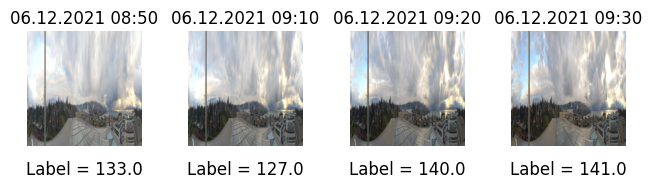

In [9]:
sample_size = 4
for i, sample in enumerate(ghi_dataset):

    ax = plt.subplot(1, sample_size, i + 1)
    plt.tight_layout()
    ax.set_title(formatted_dates_times[i], fontsize=12)
    ax.text(0.5, -0.2, f'Label = {sample[2].item()}', ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.axis('off')
    sample_display(*sample)

    if i == (sample_size-1):
      plt.savefig('images.png')
      plt.show()
      break

In [10]:
#files.download('images.png') # Save the plot in your download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following visualisation allows to highlight the yellow channel and brightness of some carefully selected images. This code has been done after the computation of the cloud detectors which showed some challenges in identifying clouds in those images. Indeed the compression of the 360° images has induced some artefacts which make the cloud detection less accurate.

The values for the brightness have been taken from this source:
Bezryadin, S., Bourov, P. and Ilinih, D. (2007) ‘Brightness calculation in digital image processing’, International Symposium on Technologies for Digital Photo Fulfillment, 1(1), pp. 10–15. doi:10.2352/issn.2169-4672.2007.1.0.10.

In [11]:
def visualize_image_and_cloud_masks(dataset, index):
    # Load the RGB image and convert it from a PyTorch tensor to a NumPy array for visualisation purposes
    image0, _, _ = dataset[index]
    image0 = np.asarray(image0.permute(1, 2, 0))

    # Extract red, green, and blue channels from image0
    red_channel = image0[:, :, 0]
    green_channel = image0[:, :, 1]
    blue_channel = image0[:, :, 2]

    # Create the yellow channel by combining red and green
    yellow_channel = red_channel + green_channel

    # Compute the brightness channel as defined by our source (see text above)
    brightness_channel = 0.299 * red_channel + 0.587 * green_channel + 0.114 * blue_channel

    # Display the original image, the yellow channel, and the brightness channel
    plt.subplot(141), plt.imshow(image0), plt.title('Original Image', fontsize=12)
    plt.axis('off')
    plt.subplot(142), plt.imshow(yellow_channel, cmap='hot'), plt.title('Yellow Channel', fontsize=12)
    plt.axis('off')
    plt.subplot(143), plt.imshow(brightness_channel, cmap='hot'), plt.title('Brightness Channel', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

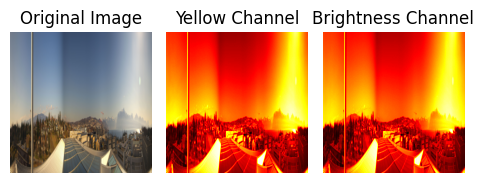

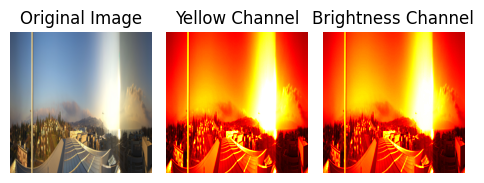

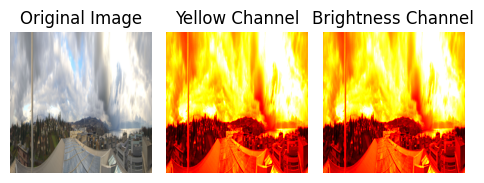

<Figure size 640x480 with 0 Axes>

In [12]:
complex_images = [1673, 913, 81]
visualize_image_and_cloud_masks(ghi_dataset, complex_images[0])
plt.savefig('complex_image_1673.png')
visualize_image_and_cloud_masks(ghi_dataset, complex_images[1])
plt.savefig('complex_image_913.png')
visualize_image_and_cloud_masks(ghi_dataset, complex_images[2])
plt.savefig('complex_image_81.png')

In [14]:
#files.download('complex_image_1673.png')
#files.download('complex_image_913.png')
#files.download('complex_image_81.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## GHI Labels (two hours later)

Let's first plot the labels in a classical plot.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

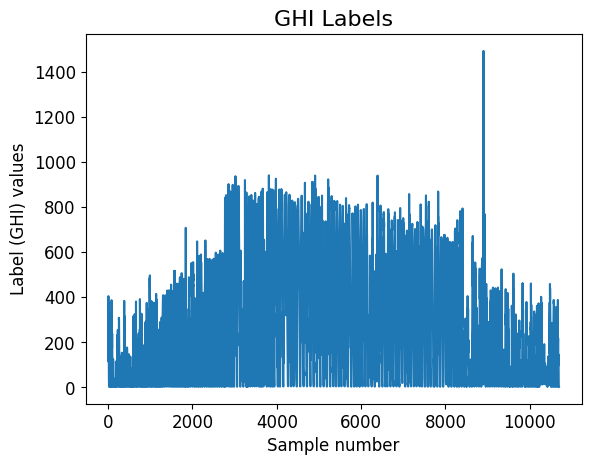

In [16]:
# Plot the labels
plt.plot(labels)
plt.title('GHI Labels', fontsize = 16)
plt.xlabel('Sample number', fontsize = 12)
plt.ylabel('Label (GHI) values', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('labels_plot.png')
#files.download('labels_plot.png') # Save the plot in your download

The plot above shows a very high value which does not represent a plausible value. We would therefore want to have a closer look at it.
In order to do that we first need to identify the index of this label and then plot the values around it.

In [17]:
np.where(labels >1400)

(array([8902]),)

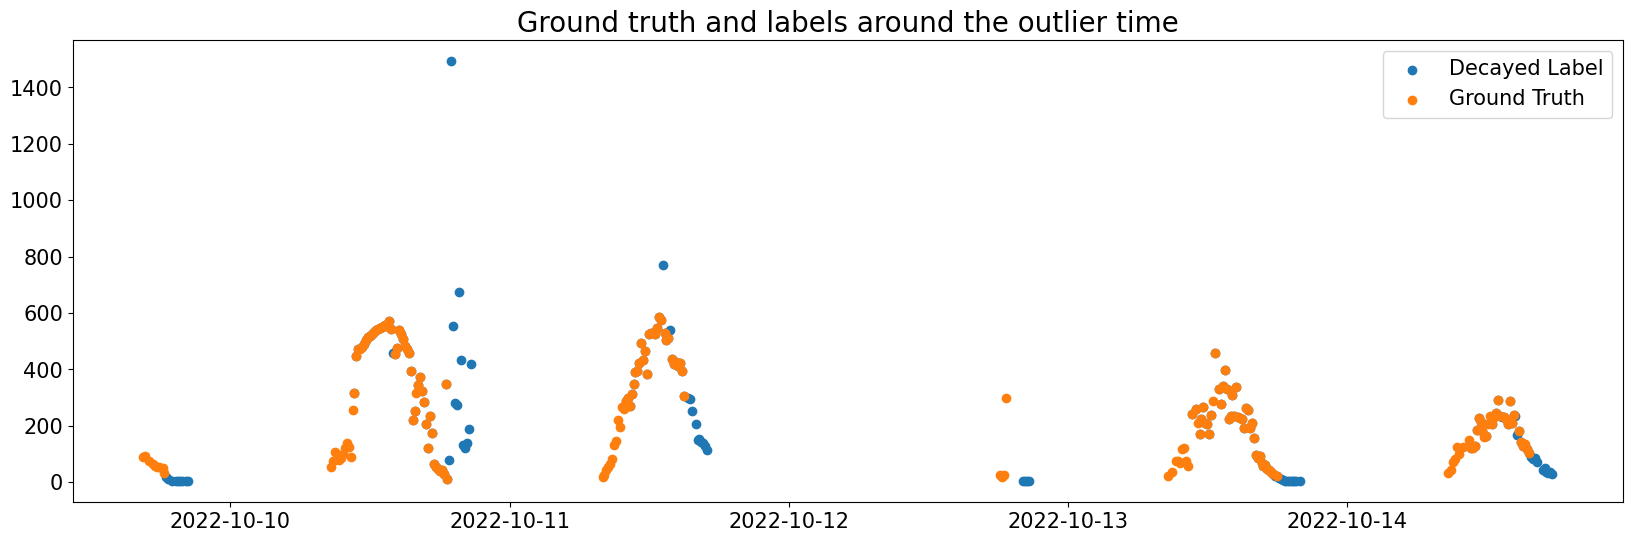

In [18]:
time = time_image
y = labels
time_range = 200
time_start = 8845
time_offset = timedelta(hours=2, minutes=0)

plt.figure(figsize=(20,6))
plt.title('Ground truth and labels around the outlier time', fontsize = 20)
plt.scatter(time[time_start:time_start+time_range]+time_offset,y[time_start:time_start+time_range],label='Decayed Label')
plt.scatter(time[time_start:time_start+time_range],ground_truth[time_start:time_start+time_range],label='Ground Truth')
plt.legend(fontsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.savefig('labels_plot_outlier.png')

In [19]:
#files.download('labels_plot_outlier.png') # Save the plot in your download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The plot above definitely seems to show outliers. We therefore would like to get their indices to adjust them for our models.
The prints below suggest that it would be necessary to change the labels 8901 to 8913.

In [20]:
print(time_image[8898], labels[8898].item(), end=',\n')
print(time_image[8900], labels[8900].item(), end=',\n')
print(time_image[8901], labels[8901].item(), end=',\n')
print(time_image[8902], labels[8902].item(), end=',\n')
print(time_image[8903], labels[8903].item(), end=',\n')
print(time_image[8904], labels[8904].item(), end=',\n')
print(time_image[8905], labels[8905].item(), end=',\n')
print(time_image[8906], labels[8906].item(), end=',\n')
print(time_image[8913], labels[8913].item(), end=',\n')
print(time_image[8914], labels[8914].item(), end=',\n')

2022-10-10 16:20:00 28.0,
2022-10-10 16:40:00 13.0,
2022-10-10 16:50:00 79.0,
2022-10-10 17:00:00 1493.0,
2022-10-10 17:10:00 555.0,
2022-10-10 17:20:00 281.0,
2022-10-10 17:30:00 275.0,
2022-10-10 17:40:00 675.0,
2022-10-11 08:00:00 287.0,
2022-10-11 08:10:00 298.0,


Let's now visualise the labels in boxplots according to their time such that all the predictions done at 13:30 are presented by the same boxplot (median, Q1, Q3). For this visualisation, we remove this very high value of more than 1400 such that the plot is more readable.

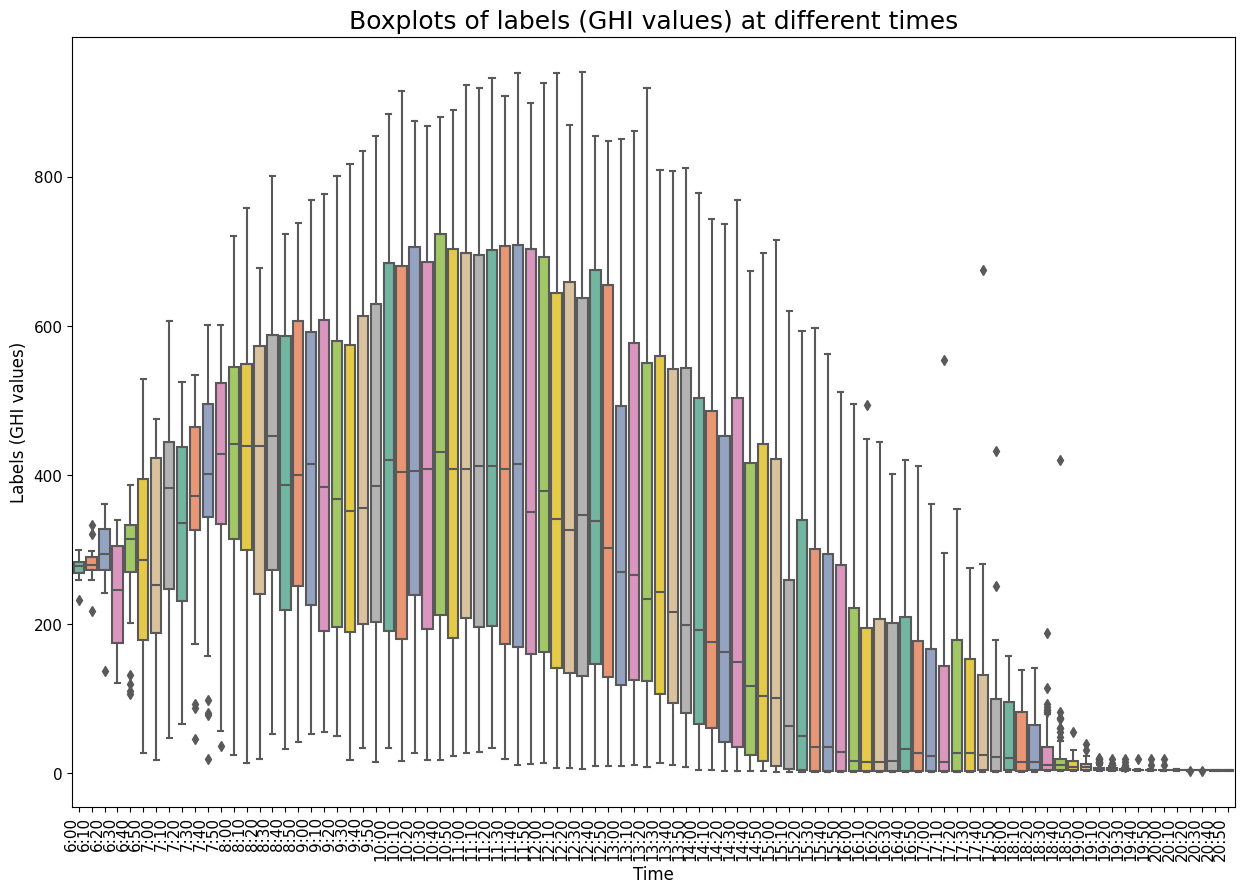

<Figure size 640x480 with 0 Axes>

In [22]:
# Create a DataFrame from combined_times (730 for 7:30) and labels
df = pd.DataFrame({'hours_minutes': combined_times, 'Labels (GHI values)': labels})
# Drop this very obvious outlier
df = df.drop(8902)
# Convert hours_minutes to string for better visualisation
df['time'] = df['hours_minutes'].astype(str)

# Sort the DataFrame by 'hours_minutes'
df.sort_values(by=['hours_minutes'], inplace=True)

# Extract 'hour' and 'minute' for better visualisation
df['hour'] = df['hours_minutes'] // 100
df['minute'] = df['hours_minutes'] % 100

# Combine 'hour' and 'minute' for x-axis labels
df['Time'] = df.apply(lambda row: f"{row['hour']}:{row['minute']:02d}", axis=1)

# Plot boxplots using seaborn
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='Time', y='Labels (GHI values)', data=df, palette='Set2', orient='v')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Labels (GHI values)', fontsize=12)
plt.title('Boxplots of labels (GHI values) at different times', fontsize = 18)
plt.xticks(rotation=90, ha='right', fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()
plt.savefig('labels_boxplot.png')

In [23]:
#files.download('labels_boxplot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The plot below shows the distribution of label values (GHI)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

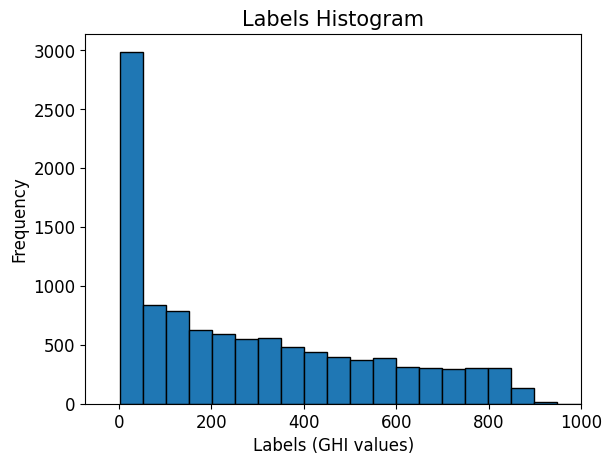

In [24]:
plt.hist(ghi_dataset.labels, bins = 30, edgecolor='black')
plt.xlim(right=1000) # This aims at removing the outlier for a better overview
plt.title('Labels Histogram', fontsize = 15)
plt.xlabel('Labels (GHI values)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('labels_his.png')
#files.download('labels_his.png') # Save the plot in your download

## Ground Truth

Let us do the same for the ground truth.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

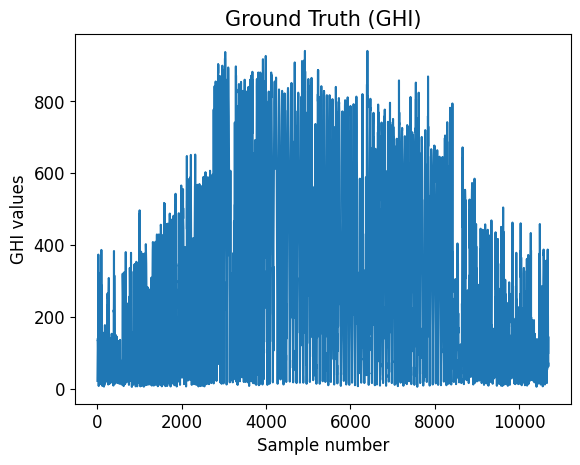

In [25]:
plt.plot(ground_truth)
plt.title('Ground Truth (GHI)', fontsize = 15)
plt.xlabel('Sample number', fontsize = 12)
plt.ylabel('GHI values', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('ground_truth_plot.png')
#files.download('ground_truth_plot.png') # Save the plot in your download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

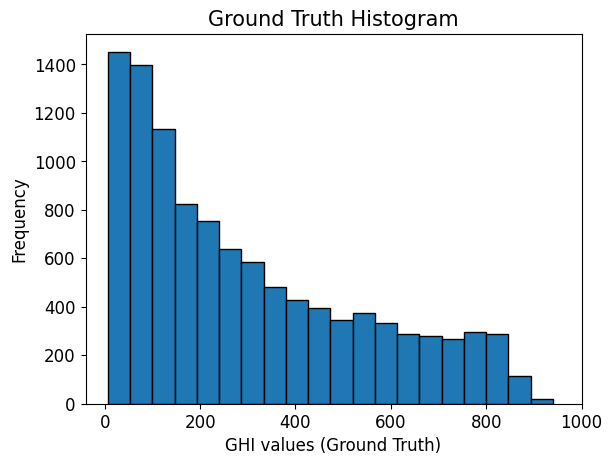

In [26]:
plt.hist(ground_truth, bins = 20, edgecolor = 'black')
plt.xlim(right=1000)
plt.title('Ground Truth Histogram', fontsize = 15)
plt.xlabel('GHI values (Ground Truth)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('ground_truth_his.png')
#files.download('ground_truth_his.png') # Save the plot in your download

The plot above does give a general idea over the year but we would also be interested in monthly visualisation.

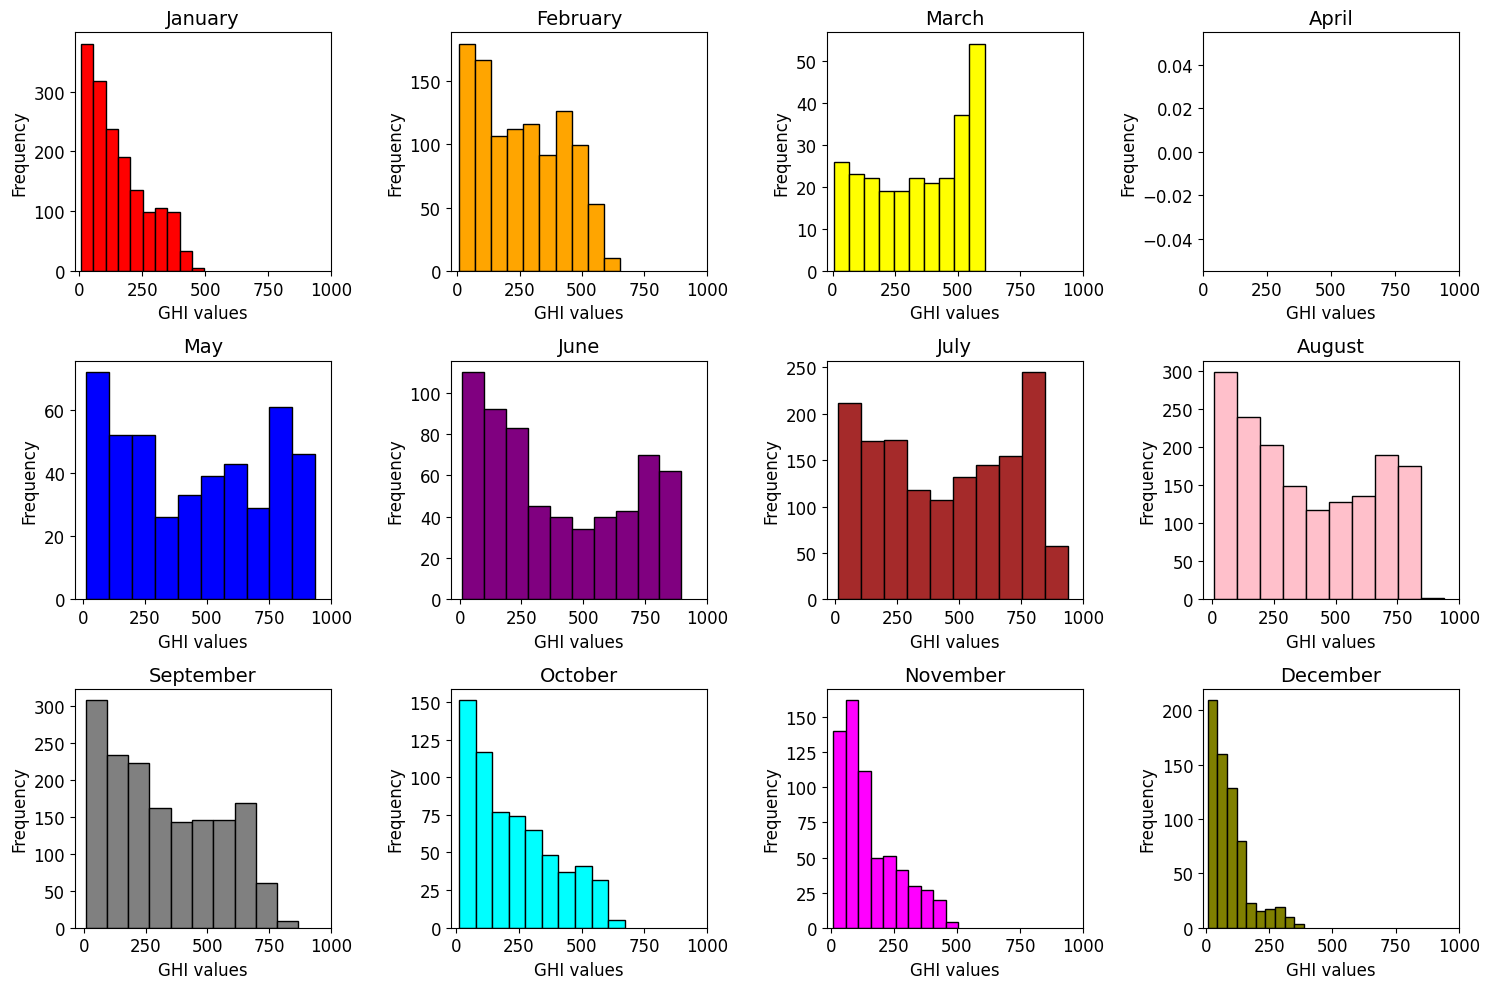

In [27]:
# Make a list of all the titles/months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with 12 subplots (one for each month)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array to ease the iterations
axes = axes.flatten()

# Iterate over all the months
for i in range(1, 13):
    # Filter data for the current month
    GHI_month = ground_truth[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].hist(GHI_month, color=colors[i-1], edgecolor='black')
    axes[i-1].set_title(title[i-1], fontsize = 14)
    axes[i-1].set_xlabel('GHI values', fontsize = 12)
    axes[i-1].set_ylabel('Frequency', fontsize = 12)
    axes[i-1].tick_params(axis='y', labelsize=12)
    axes[i-1].tick_params(axis='x', labelsize=12)
    axes[i-1].set_xlim(right=1000)

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('GHI_AllMonths.png')
plt.show()


In [28]:
#files.download('GHI_AllMonths.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

These graphs show us how much the GHI depends on the month. Since we only have approximately a year's worth of data it is important for us to still train on every month. For the validation set, it might also be wise to take some data from multiple different months. This would allow us not to bias our model towards or away from a certain month. Unfortunatly, we know our model should not be considered to predict very accurate GHI values for the month of April as it has never seen data from this specific month.

## Image Date

Let's visualise the date of the images to make sure to see how the data is distributed over the year.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

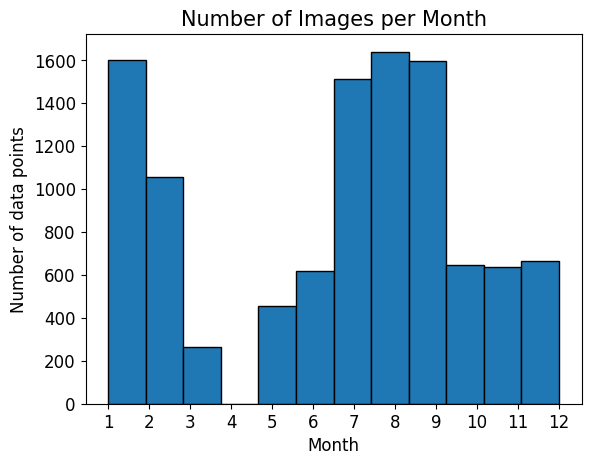

In [29]:
plt.hist(month_values_image, bins = 12, edgecolor = 'black')
plt.title('Number of Images per Month', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Number of data points', fontsize = 12)
plt.xticks(range(1, 13))
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('image_date_his.png')
#files.download('image_date_his.png') # Save the plot in your download

We can see from the histogram that there is no data in April. This is due to a fire that happened on campus.

## Meteo Wind

Now let's see how the wind behaves in Lausanne throughout the year.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

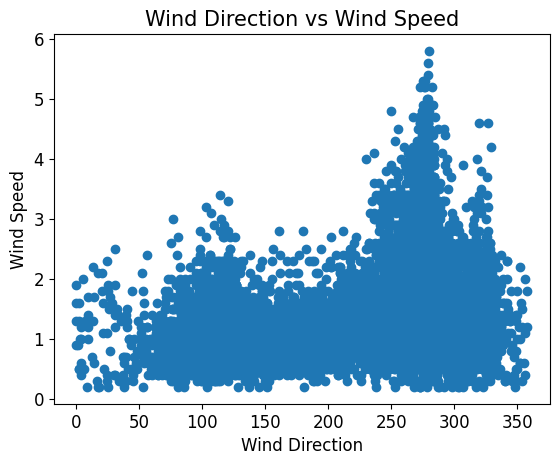

In [30]:
plt.scatter(wind_dir, wind_speed)
plt.title('Wind Direction vs Wind Speed', fontsize = 15)
plt.xlabel('Wind Direction', fontsize = 12)
plt.ylabel('Wind Speed', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('meteo_wind_scatter.png')
#files.download('meteo_wind_scatter.png') # Save the plot in your download

We can see from this plot that we have the highest wind speed in the 250-300 wind direction. There does not seem to be many recorded data with a wind direction around 0-50. The question would now be: is there a bias according to the month or can we observe the same distribution all year long?

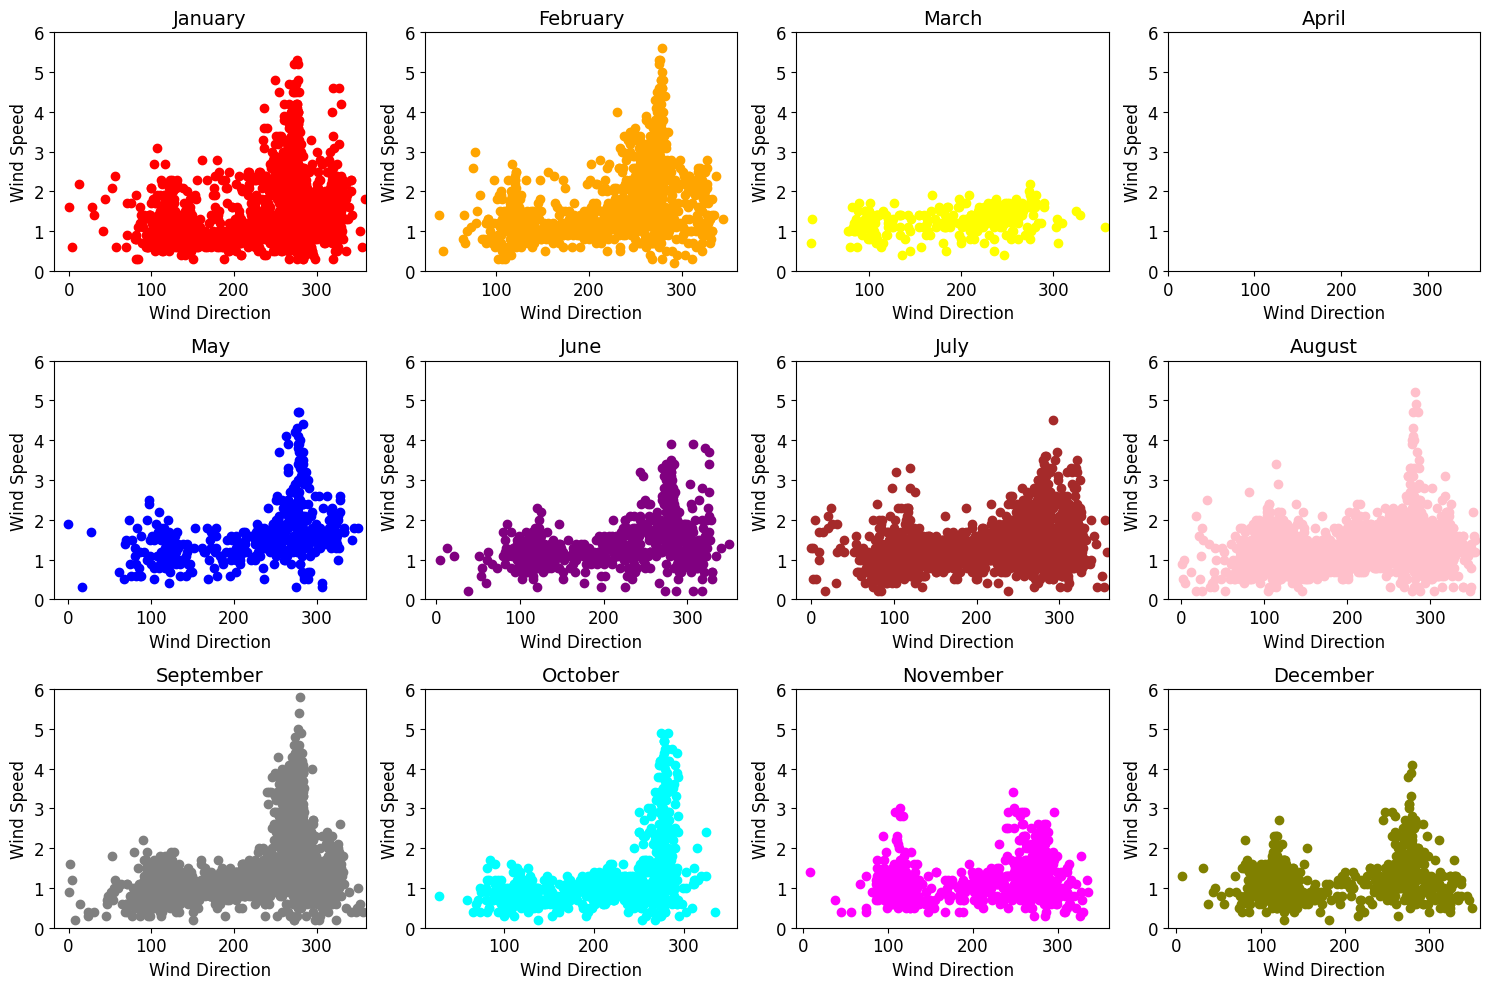

In [31]:
# Subplots of the above scatter plot
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(1, 13):
    # Filter data for the current month
    wind_dir_month = wind_dir[np.where(np.isclose(month_values_meteo, i))]
    wind_speed_month = wind_speed[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].scatter(wind_dir_month, wind_speed_month, color=colors[i-1])
    axes[i-1].set_title(f'{title[i-1]}', fontsize = 14)
    axes[i-1].set_xlabel('Wind Direction', fontsize = 12)
    axes[i-1].set_ylabel('Wind Speed', fontsize = 12)
    axes[i-1].set_xlim(right=360)
    axes[i-1].set_ylim((0,6))
    axes[i-1].tick_params(axis='y', labelsize=12)
    axes[i-1].tick_params(axis='x', labelsize=12)

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('meteo_wind_scatter_AllMonths.png')
plt.show()


In [32]:
#files.download('meteo_wind_scatter_AllMonths.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

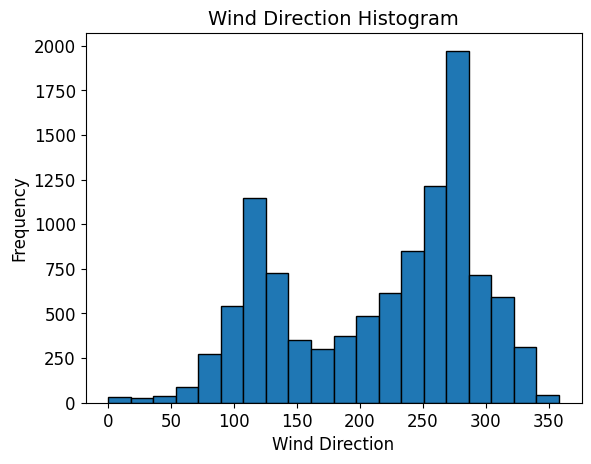

In [33]:
plt.hist(wind_dir, bins = 20, edgecolor = 'black')
plt.title('Wind Direction Histogram', fontsize = 14)
plt.xlabel('Wind Direction', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('Wind Direction Histogram.png')
#files.download('Wind Direction Histogram.png')
plt.show()

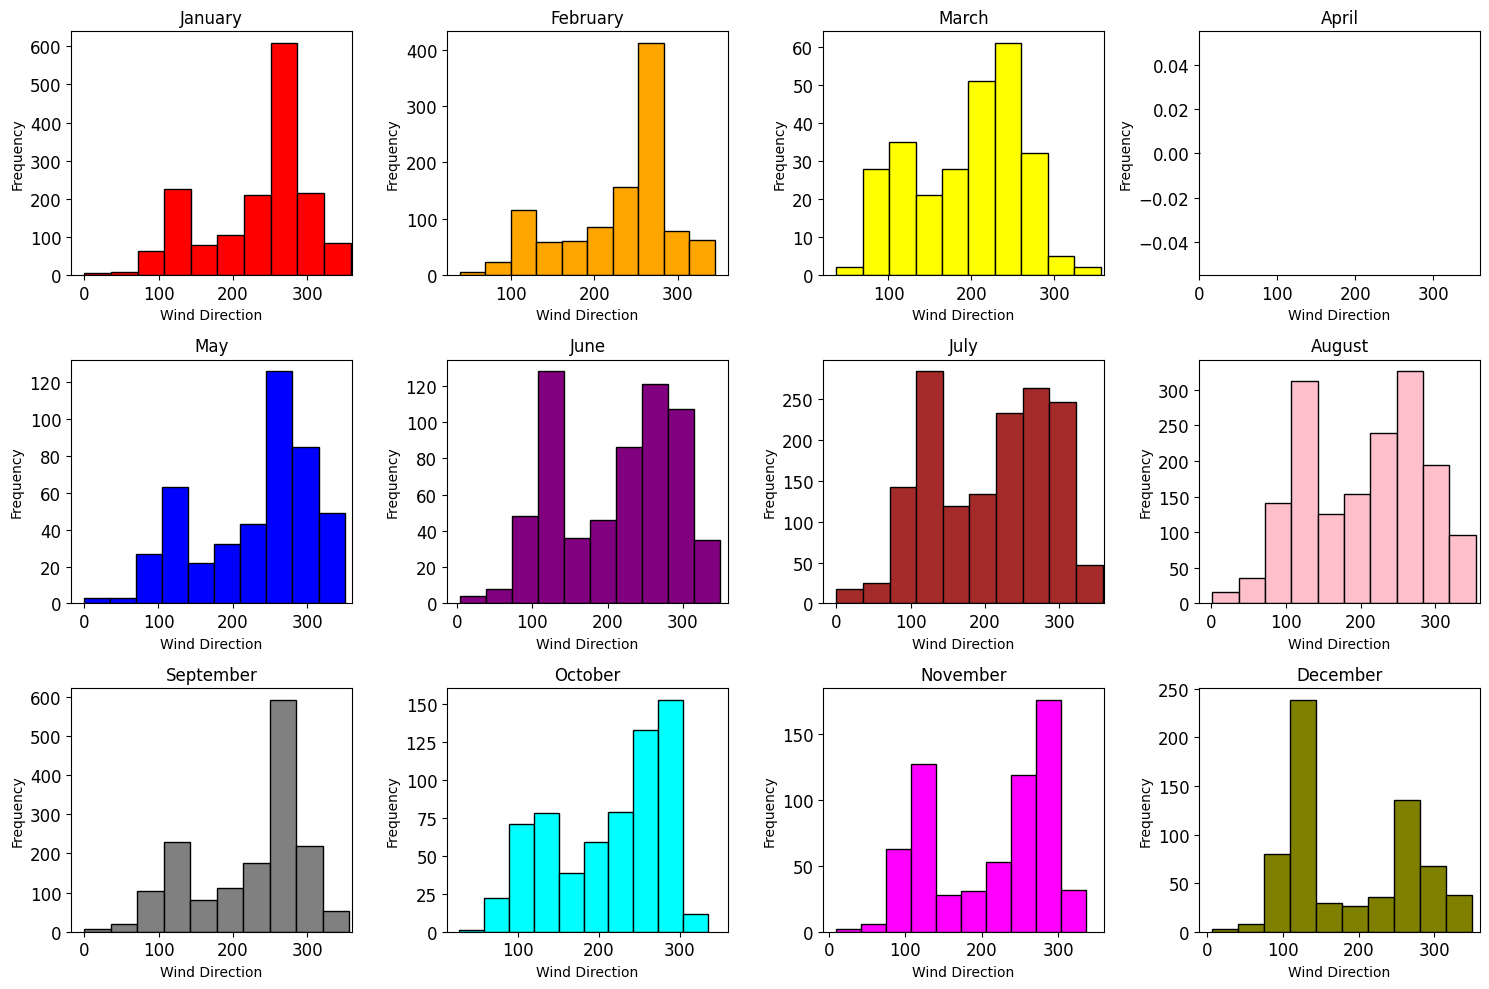

In [34]:
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(1, 13):
    # Filter data for the current month
    wind_dir_month = wind_dir[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].hist(wind_dir_month, color=colors[i-1], edgecolor = 'black')
    axes[i-1].set_title(f'{title[i-1]}')
    axes[i-1].set_xlabel('Wind Direction')
    axes[i-1].set_ylabel('Frequency')
    axes[i-1].tick_params(axis='y', labelsize=12)
    axes[i-1].tick_params(axis='x', labelsize=12)
    axes[i-1].set_xlim(right=360)

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('wind_dir_AllMonths.png')
plt.show()


In [35]:
#files.download('wind_dir_AllMonths.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

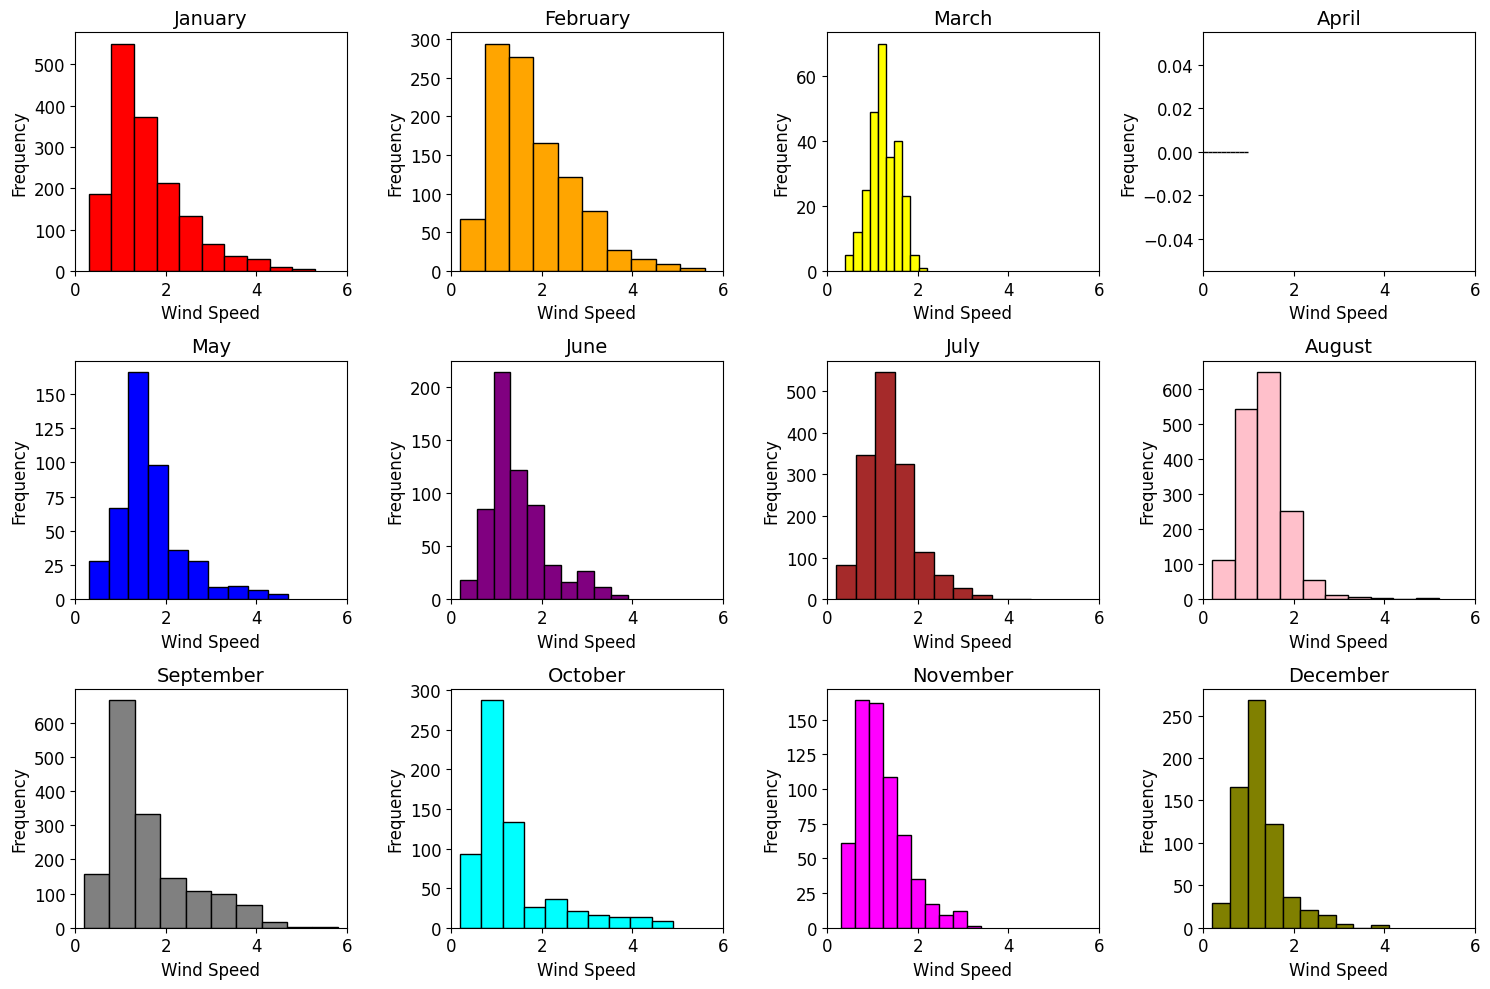

In [36]:
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()


for i in range(1, 13):
    # Filter data for the current month
    wind_speed_month = wind_speed[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].hist(wind_speed_month, color=colors[i-1], edgecolor = 'black')
    axes[i-1].set_title(f'{title[i-1]}', fontsize = 14)
    axes[i-1].set_xlabel('Wind Speed', fontsize = 12)
    axes[i-1].set_ylabel('Frequency', fontsize = 12)
    axes[i-1].tick_params(axis='y', labelsize=12)
    axes[i-1].tick_params(axis='x', labelsize=12)
    axes[i-1].set_xlim([0, 6])


# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('wind_speed_AllMonths.png')
plt.show()

In [37]:
#files.download('wind_speed_AllMonths.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can see from these plots that not all months have the same scatter distribution.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

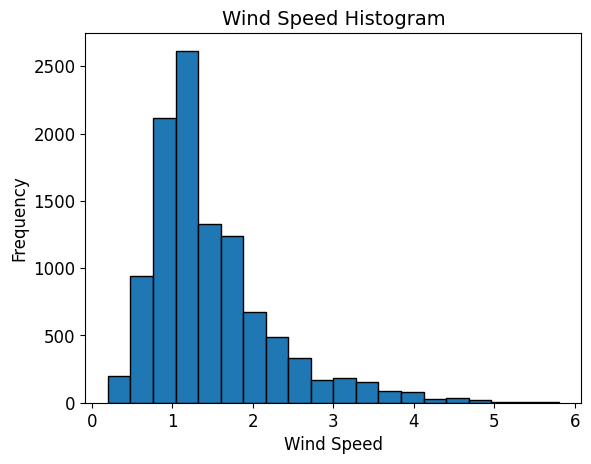

In [38]:
plt.hist(wind_speed, bins = 20, edgecolor = 'black')
plt.title('Wind Speed Histogram', fontsize = 14)
plt.xlabel('Wind Speed', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('Wind Speed Histogram.png')
#files.download('Wind Speed Histogram.png')
plt.show()

Another kind of visualisation which might help understand the data is boxplots.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

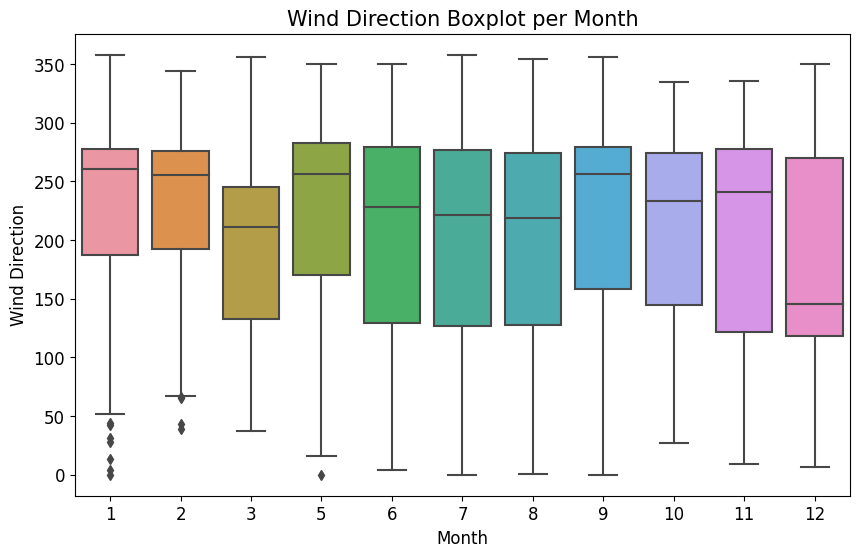

In [39]:
# Generate a dataframe using the wind direction and month to allow the visualisation of this data per month
data_boxplot_wind_dir = {
    'Wind Direction': wind_dir,
    'Month': month_values_meteo
}
df = pd.DataFrame(data_boxplot_wind_dir)

# Create one boxplot per month for the wind direction using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Wind Direction', data=df)

# Add labels and title
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Wind Direction', fontsize = 12)
plt.title('Wind Direction Boxplot per Month', fontsize = 15)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.savefig('Wind Direction Boxplot.png')
#files.download('Wind Direction Boxplot.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

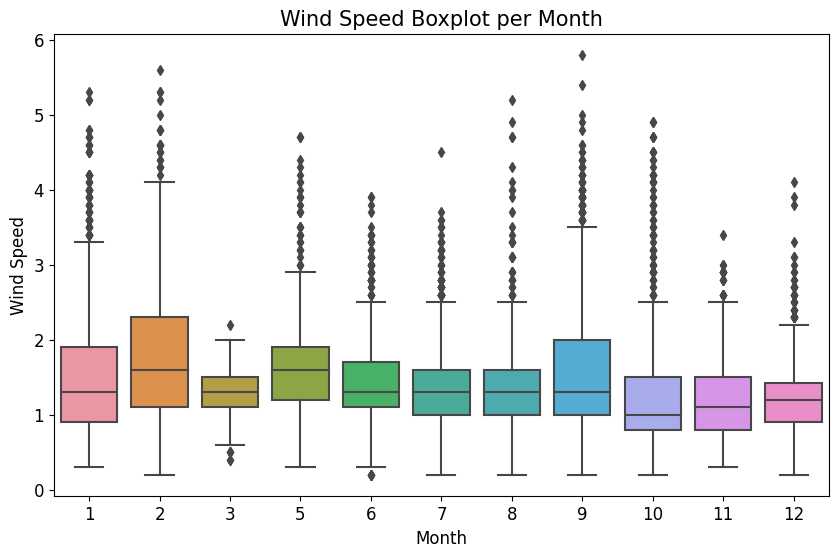

In [40]:
# Generate a dataframe using the wind speed and month to allow the visualisation of this data per month
data_boxplot_wind_speed = {
    'Wind Speed': wind_speed,
    'Month': month_values_meteo
}

df = pd.DataFrame(data_boxplot_wind_speed)
# Create a boxplot per month using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Wind Speed', data=df)

# Add labels and title
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Wind Speed', fontsize = 12)
plt.title('Wind Speed Boxplot per Month', fontsize = 15)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.savefig('Wind Speed Boxplot.png')
#files.download('Wind Speed Boxplot.png')
plt.show()

## Meteo Air Temperature

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

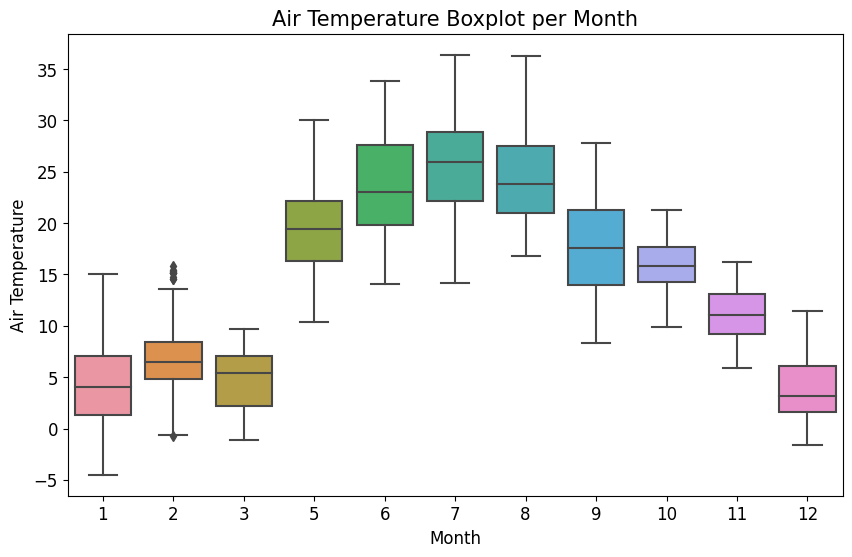

In [41]:
# Generate a dataframe using the air temperature and month to allow the visualisation of this data per month
data_boxplot_air_temp = {
    'Air Temp': air_temp,
    'Month': month_values_meteo
}

df = pd.DataFrame(data_boxplot_air_temp)
# Create a boxplot per month using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Air Temp', data=df)

# Add labels and title
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Air Temperature', fontsize = 12)
plt.title('Air Temperature Boxplot per Month', fontsize = 15)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.savefig('Air Temperature Boxplot.png')
#files.download('Air Temperature Boxplot.png')
plt.show()

## Meteo Time

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

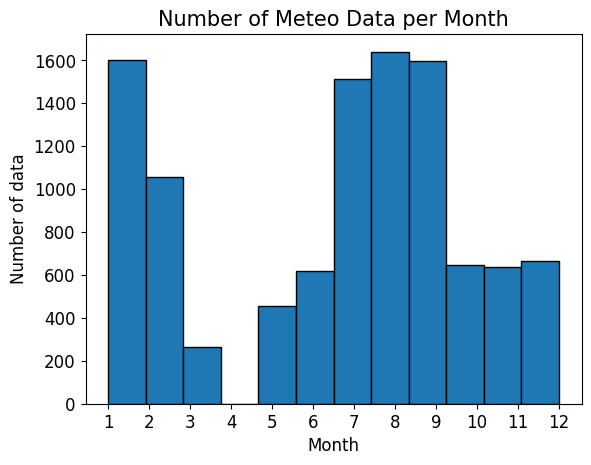

In [42]:
plt.hist(month_values_meteo, bins = 12, edgecolor = 'black')
plt.title('Number of Meteo Data per Month', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Number of data', fontsize = 12)
plt.xticks(range(1, 13))
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.savefig('meteo_month_values.png')
#files.download('meteo_month_values.png')


## Elapsed Time

Since we aim to model time dependence between the data we wish to visualise the time elapsed between a point and the previous one. Theoretically, it should be mostly 10 minutes as this is the sampling rate when everything can be recorded. However, the time lapse between the last image of one day and the first image of the next day.

In [43]:
# Assuming time_image is a list of datetime objects
#date_times = time_image

# Create a new DataFrame based on the time stamps of the data (images)
df = pd.DataFrame(time_image, columns=['datetime'])

# Sort the DataFrame based on the datetime feature. This should already be the case but we do it just in case.
df = df.sort_values('datetime')

# Group by month
df['month'] = df['datetime'].dt.month
grouped = df.groupby('month')

# Calculate the time difference between consecutive points for each month
df['elapsed_time'] = grouped['datetime'].diff()

# Convert the time difference to minutes
df['elapsed_time_minutes'] = df['elapsed_time'].dt.total_seconds() / 60

# Display the DataFrame
print(df)


                 datetime  month    elapsed_time  elapsed_time_minutes
0     2021-12-06 08:50:00     12             NaT                   NaN
1     2021-12-06 09:10:00     12 0 days 00:20:00                  20.0
2     2021-12-06 09:20:00     12 0 days 00:10:00                  10.0
3     2021-12-06 09:30:00     12 0 days 00:10:00                  10.0
4     2021-12-06 09:50:00     12 0 days 00:20:00                  20.0
...                   ...    ...             ...                   ...
10688 2023-01-23 15:10:00      1 0 days 00:10:00                  10.0
10689 2023-01-23 15:20:00      1 0 days 00:10:00                  10.0
10690 2023-01-23 15:30:00      1 0 days 00:10:00                  10.0
10691 2023-01-23 15:40:00      1 0 days 00:10:00                  10.0
10692 2023-01-23 15:50:00      1 0 days 00:10:00                  10.0

[10693 rows x 4 columns]


In [44]:
months_2 = df['month']
elapsed_time_minutes_ = df['elapsed_time_minutes']
# Time lapses of more than 1000 minutes (~16 hours) are set to -5 in order to have histograms which are not too far spread out on the x axis
elapsed_time_minutes_2 = np.where(elapsed_time_minutes_ > 1000, -5, elapsed_time_minutes_)


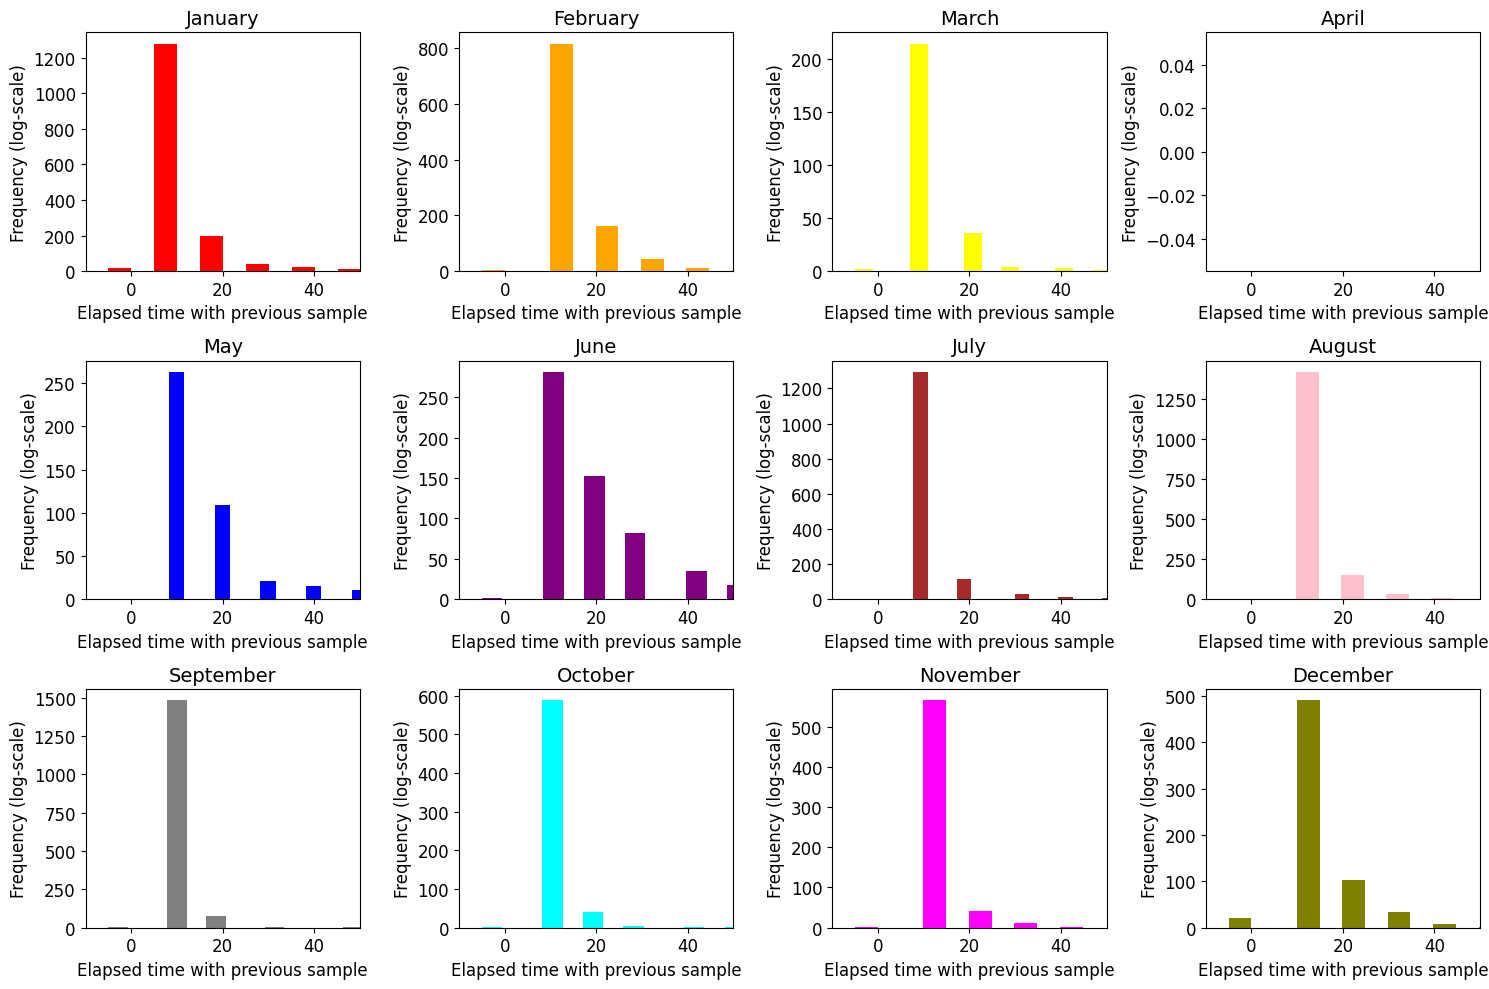

In [45]:
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()


for i in range(1, 13):
    # Filter data for the current month
    elapsed_time_month_i = elapsed_time_minutes_2[months_2 == i]
    # Plot on the corresponding subplot
    #axes[i-1].hist(np.log(elapsed_time_month_i+1), color=colors[i-1], bins = 100) #uncomment this line to have the log scaled histogram
    axes[i-1].hist(elapsed_time_month_i, color=colors[i-1], bins = 200)
    axes[i-1].set_title(f'{title[i-1]}', fontsize = 14)
    axes[i-1].set_xlabel('Elapsed time with previous sample', fontsize = 12)
    axes[i-1].set_ylabel('Frequency (log-scale)', fontsize = 12)
    axes[i-1].tick_params(axis='y', labelsize=12)
    axes[i-1].tick_params(axis='x', labelsize=12)
    axes[i-1].set_xlim([-10, 50]) #uncomment this line to set some boundaries for the x-axis


# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('elapsed_time_AllMonths.png')
plt.show()

In [46]:
#files.download('elapsed_time_AllMonths.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Number of data per day

Let's approximate the time of the length of a day is maximally 15hours and minimally 9 hours. This is respectively equivalent to approximately 90 and 54 images every 10 minutes
https://www.donneesmondiales.com/europe/suisse/coucher-soleil.php

In [47]:
# Let's now count the number of data collected per day (based on day.month.year) and plot them into a histogram
date_counts = Counter(combined_dates)
counts = date_counts.values()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

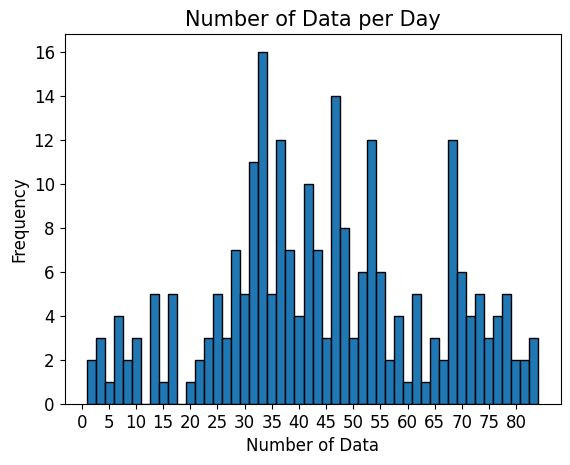

In [48]:
plt.hist(counts, bins = 50, edgecolor = 'black')
plt.title('Number of Data per Day', fontsize = 15)
plt.xlabel('Number of Data', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.xticks(range(0, 85, 5))
plt.savefig('NbOfDataPerDay.png')
#files.download('NbOfDataPerDay.png')